# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install libraries

In [2]:
!pip install prophet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Libraries

In [3]:
#Load the required libraries

import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('seaborn-v0_8-darkgrid')


from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

import joblib


import prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree

import tensorflow as tf
from keras.models import Sequential,load_model
from keras.layers import Dropout, Dense, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler


from pylab import rcParams
rcParams['figure.figsize'] = 14, 8


# from matplotlib import rc

# sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# RANDOM_SEED = 42

# np.random.seed(RANDOM_SEED)

# Import Data

In [4]:
data_ETH = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/01 Omdena/Bahrain - Crypto/Project_Data/binance/ETHUSDT_merged.csv")

In [5]:
data_ETH.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2019-09-01 00:00:00,171.52,172.89,171.36,172.45,5981.16399,2019-09-01 00:59:59.999,1.030126e+06,3753,3576.32332,615886.585686
1,2019-09-01 01:00:00,172.47,173.42,172.41,172.71,7929.54701,2019-09-01 01:59:59.999,1.372183e+06,3310,5532.93656,957301.238661
2,2019-09-01 02:00:00,172.67,172.97,172.02,172.43,2650.04457,2019-09-01 02:59:59.999,4.568114e+05,2666,1333.25886,229852.921103
3,2019-09-01 03:00:00,172.41,172.83,172.32,172.57,2676.49085,2019-09-01 03:59:59.999,4.618308e+05,2612,1445.60395,249450.124375
4,2019-09-01 04:00:00,172.50,172.74,172.11,172.46,2596.85893,2019-09-01 04:59:59.999,4.476401e+05,2848,1524.31952,262782.612091


Here's a breakdown of each feature:

- **open_time**: This represents the opening time of a specific period in Unix time format. Unix time is a way to represent time as the number of seconds that have elapsed since January 1, 1970.

- **open**: This refers to the opening price of the trading instrument at the given period.

- **high**: This represents the highest price reached by the trading instrument during the specified period.

- **low**: This denotes the lowest price reached by the trading instrument during the specified period.

- **close**: This indicates the closing price of the trading instrument at the given period.

- **volume**: This refers to the total volume, typically the quantity of the trading instrument, traded during the specified period.

- **close_time**: This represents the closing time of the specific period in Unix time format.

- **quote_volume**: This refers to the total volume in terms of the quote asset. The quote asset is the asset used to determine the value of the trading instrument.

- **count**: This represents the number of trades that occurred during the specified period.

- **taker_buy_volume**: This denotes the volume of the quote asset bought by takers (market takers) during the specified period.

- **taker_buy_quote_volume**: This represents the volume of the base asset bought by takers (market takers) during the specified period.

In [6]:
# Renaming the columns to match the name in the previous notebook with bitstamp data so that I do not have to change the whole code
data_ETH.rename(columns = {'open_time':'date', 'volume':'Volume'}, inplace = True)

In [7]:
data_ETH.head()

,date,open,high,low,close,Volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2019-09-01 00:00:00,171.52,172.89,171.36,172.45,5981.16399,2019-09-01 00:59:59.999,1.030126e+06,3753,3576.32332,615886.585686
1,2019-09-01 01:00:00,172.47,173.42,172.41,172.71,7929.54701,2019-09-01 01:59:59.999,1.372183e+06,3310,5532.93656,957301.238661
2,2019-09-01 02:00:00,172.67,172.97,172.02,172.43,2650.04457,2019-09-01 02:59:59.999,4.568114e+05,2666,1333.25886,229852.921103
3,2019-09-01 03:00:00,172.41,172.83,172.32,172.57,2676.49085,2019-09-01 03:59:59.999,4.618308e+05,2612,1445.60395,249450.124375
4,2019-09-01 04:00:00,172.50,172.74,172.11,172.46,2596.85893,2019-09-01 04:59:59.999,4.476401e+05,2848,1524.31952,262782.612091


In [8]:
data_ETH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32821 entries, 0 to 32820
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    32821 non-null  object 
 1   open                    32821 non-null  float64
 2   high                    32821 non-null  float64
 3   low                     32821 non-null  float64
 4   close                   32821 non-null  float64
 5   Volume                  32821 non-null  float64
 6   close_time              32821 non-null  object 
 7   quote_volume            32821 non-null  float64
 8   count                   32821 non-null  int64  
 9   taker_buy_volume        32821 non-null  float64
 10  taker_buy_quote_volume  32821 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 2.8+ MB


In [9]:
# Removing close time column

data_ETH = data_ETH.drop(columns=['close_time'])

In [10]:
data_ETH.head()

,date,open,high,low,close,Volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2019-09-01 00:00:00,171.52,172.89,171.36,172.45,5981.16399,1.030126e+06,3753,3576.32332,615886.585686
1,2019-09-01 01:00:00,172.47,173.42,172.41,172.71,7929.54701,1.372183e+06,3310,5532.93656,957301.238661
2,2019-09-01 02:00:00,172.67,172.97,172.02,172.43,2650.04457,4.568114e+05,2666,1333.25886,229852.921103
3,2019-09-01 03:00:00,172.41,172.83,172.32,172.57,2676.49085,4.618308e+05,2612,1445.60395,249450.124375
4,2019-09-01 04:00:00,172.50,172.74,172.11,172.46,2596.85893,4.476401e+05,2848,1524.31952,262782.612091


# EDA

## Converting to Datetime

In [11]:
# Converting the Date column from object to datetime
data_ETH[["date"]] = data_ETH[["date"]].apply(pd.to_datetime)

In [12]:
data_ETH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32821 entries, 0 to 32820
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    32821 non-null  datetime64[ns]
 1   open                    32821 non-null  float64       
 2   high                    32821 non-null  float64       
 3   low                     32821 non-null  float64       
 4   close                   32821 non-null  float64       
 5   Volume                  32821 non-null  float64       
 6   quote_volume            32821 non-null  float64       
 7   count                   32821 non-null  int64         
 8   taker_buy_volume        32821 non-null  float64       
 9   taker_buy_quote_volume  32821 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 2.5 MB


## Missing Data

In [13]:
data_ETH.isnull().any()

date                      False
open                      False
high                      False
low                       False
close                     False
Volume                    False
quote_volume              False
count                     False
taker_buy_volume          False
taker_buy_quote_volume    False
dtype: bool

# Modeling

In [14]:
data_ETH.shape

(32821, 10)

## FB Prophet

In [15]:
# Train/Test split

df_train = data_ETH[data_ETH.date < "2022-09-01"]
df_test = data_ETH[data_ETH.date >= "2022-09-01"]

In [16]:
df_train

,date,open,high,low,close,Volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2019-09-01 00:00:00,171.52,172.89,171.36,172.45,5981.16399,1.030126e+06,3753,3576.32332,6.158866e+05
1,2019-09-01 01:00:00,172.47,173.42,172.41,172.71,7929.54701,1.372183e+06,3310,5532.93656,9.573012e+05
2,2019-09-01 02:00:00,172.67,172.97,172.02,172.43,2650.04457,4.568114e+05,2666,1333.25886,2.298529e+05
3,2019-09-01 03:00:00,172.41,172.83,172.32,172.57,2676.49085,4.618308e+05,2612,1445.60395,2.494501e+05
4,2019-09-01 04:00:00,172.50,172.74,172.11,172.46,2596.85893,4.476401e+05,2848,1524.31952,2.627826e+05
...,...,...,...,...,...,...,...,...,...,...
26265,2022-08-31 19:00:00,1548.76,1588.78,1548.01,1575.33,53487.22770,8.409498e+07,70035,28314.06030,4.451187e+07
26266,2022-08-31 20:00:00,1575.33,1578.96,1564.08,1570.36,17599.02940,2.764530e+07,33873,8651.38260,1.358975e+07
26267,2022-08-31 21:00:00,1570.35,1582.28,1564.55,1579.41,12630.93240,1.989094e+07,27550,6049.10790,9.528990e+06
26268,2022-08-31 22:00:00,1579.40,1584.66,1553.93,1568.57,27269.42560,4.268974e+07,42007,12938.81700,2.026207e+07


In [17]:
columns = ['open', 'high', 'low', 'Volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume']

In [19]:
# Modelling

model_fbprophet = Prophet()

for feature in columns:
    model_fbprophet.add_regressor(feature)

# FB Prophet requires to remane the columns to "ds" and "y"
model_fbprophet.fit(df_train[["date", "close"] + columns].rename(columns={"date": "ds", "close": "y"}))

forecast_fb = model_fbprophet.predict(df_test[["date", "close"] + columns].rename(columns={"date": "ds"}))

forecast_fb.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqg2oiv31/nwu9j5x3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqg2oiv31/uico1hwd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45761', 'data', 'file=/tmp/tmpqg2oiv31/nwu9j5x3.json', 'init=/tmp/tmpqg2oiv31/uico1hwd.json', 'output', 'file=/tmp/tmpqg2oiv31/prophet_modelu8tseo4w/prophet_model-20230619224357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:44:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Volume,Volume_lower,Volume_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-09-01 00:00:00,1547.954159,1534.800079,1559.637992,1547.954159,1547.954159,0.999878,0.999878,0.999878,-1.168718,...,-0.087401,-0.087401,-0.087401,6.862669,6.862669,6.862669,0.0,0.0,0.0,1546.785442
1,2022-09-01 01:00:00,1547.951952,1545.390296,1569.208318,1547.951952,1547.951952,-0.155189,-0.155189,-0.155189,8.921132,...,-0.102116,-0.102116,-0.102116,6.856558,6.856558,6.856558,0.0,0.0,0.0,1556.873084
2,2022-09-01 02:00:00,1547.949744,1549.350114,1573.122118,1547.949744,1547.949744,-0.430229,-0.430229,-0.430229,13.446865,...,-0.116546,-0.116546,-0.116546,6.850425,6.850425,6.850425,0.0,0.0,0.0,1561.396610
3,2022-09-01 03:00:00,1547.947537,1535.775622,1560.117935,1547.947537,1547.947537,-0.271278,-0.271278,-0.271278,-0.347490,...,-0.130548,-0.130548,-0.130548,6.844272,6.844272,6.844272,0.0,0.0,0.0,1547.600047
4,2022-09-01 04:00:00,1547.945329,1536.897361,1560.577174,1547.945329,1547.945329,-0.899650,-0.899650,-0.899650,0.179956,...,-0.143979,-0.143979,-0.143979,6.838098,6.838098,6.838098,0.0,0.0,0.0,1548.125286


- **ds** is the time series data.

- **yhat** is the prediction

- **yhat_lower**, and **yhat_upper** are the uncertainty levels(it basically means the prediction and actual values can vary within the bounds of the uncertainty levels)

- **trend** shows the long-term growth, shrink, or stagnancy of the data

- **trend_lower**, and **trend_upper** is the uncertainty levels

In [20]:
# Create Forecast Column

df_test["Forecast_Prophet"] = forecast_fb.yhat.values

<ipython-input-20-988780344c9c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Forecast_Prophet"] = forecast_fb.yhat.values


In [21]:
df_test

,date,open,high,low,close,Volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,Forecast_Prophet
26270,2022-09-01 00:00:00,1554.11,1566.53,1533.92,1551.37,50605.2400,7.845130e+07,63466,23466.4157,3.639579e+07,1546.785442
26271,2022-09-01 01:00:00,1551.38,1564.75,1548.02,1559.59,30348.1329,4.719890e+07,43616,16281.1037,2.531708e+07,1556.873084
26272,2022-09-01 02:00:00,1559.58,1573.98,1550.99,1557.13,25524.6036,3.992558e+07,38363,11527.2787,1.803082e+07,1561.396610
26273,2022-09-01 03:00:00,1557.13,1563.78,1537.23,1549.91,28312.2132,4.390564e+07,49287,15010.9206,2.327512e+07,1547.600047
26274,2022-09-01 04:00:00,1549.92,1557.10,1542.46,1551.79,17292.0794,2.682018e+07,39359,9156.7732,1.420323e+07,1548.125286
...,...,...,...,...,...,...,...,...,...,...,...
32816,2023-05-31 19:00:00,1864.00,1869.75,1861.62,1863.63,7481.4873,1.395814e+07,12990,3109.6255,5.800020e+06,1843.416035
32817,2023-05-31 20:00:00,1863.63,1868.80,1863.20,1865.18,5792.0252,1.080898e+07,14175,2874.1872,5.363770e+06,1844.248389
32818,2023-05-31 21:00:00,1865.17,1866.19,1861.48,1864.20,4703.4753,8.767031e+06,10517,2218.9682,4.135989e+06,1840.197868
32819,2023-05-31 22:00:00,1864.19,1871.27,1863.72,1869.42,6868.3499,1.282247e+07,10131,3404.9987,6.357285e+06,1846.073473


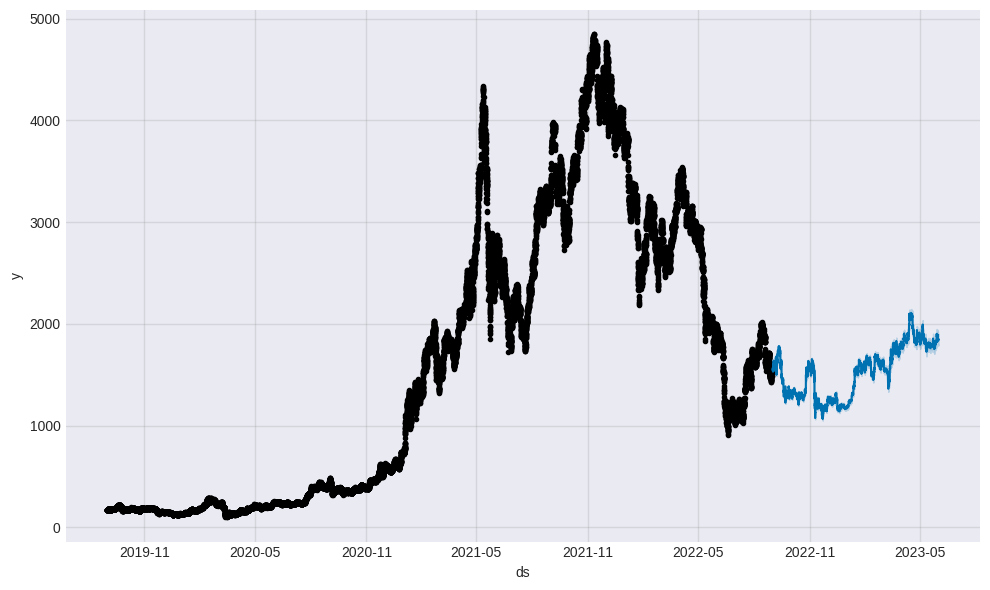

In [22]:
# Plot Our Predictions

fig1 = model_fbprophet.plot(forecast_fb)

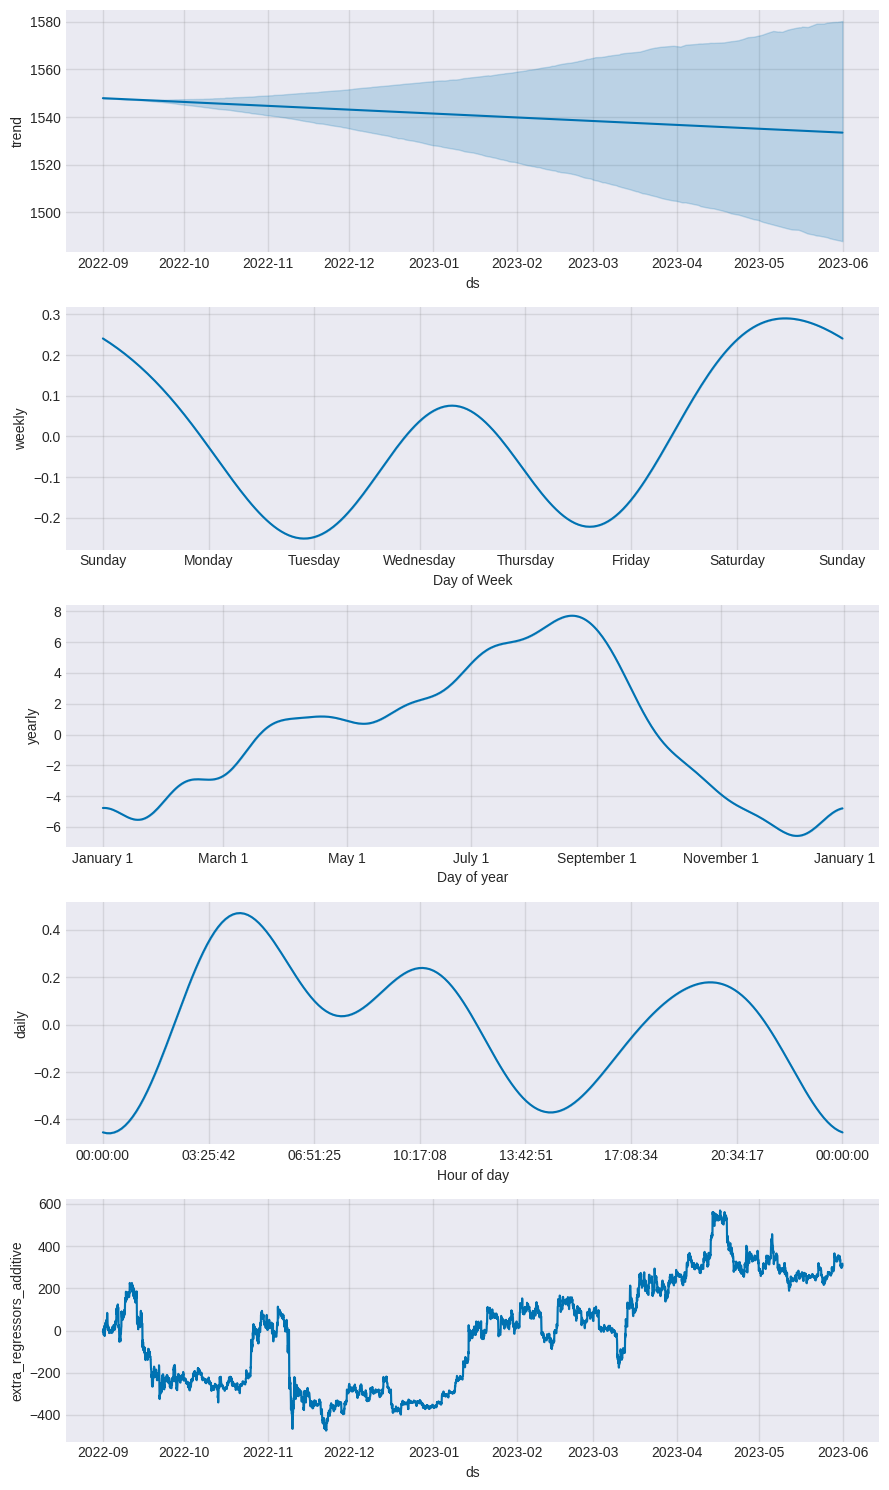

In [23]:
# Plot the predictions

fig2 = model_fbprophet.plot_components(forecast_fb)


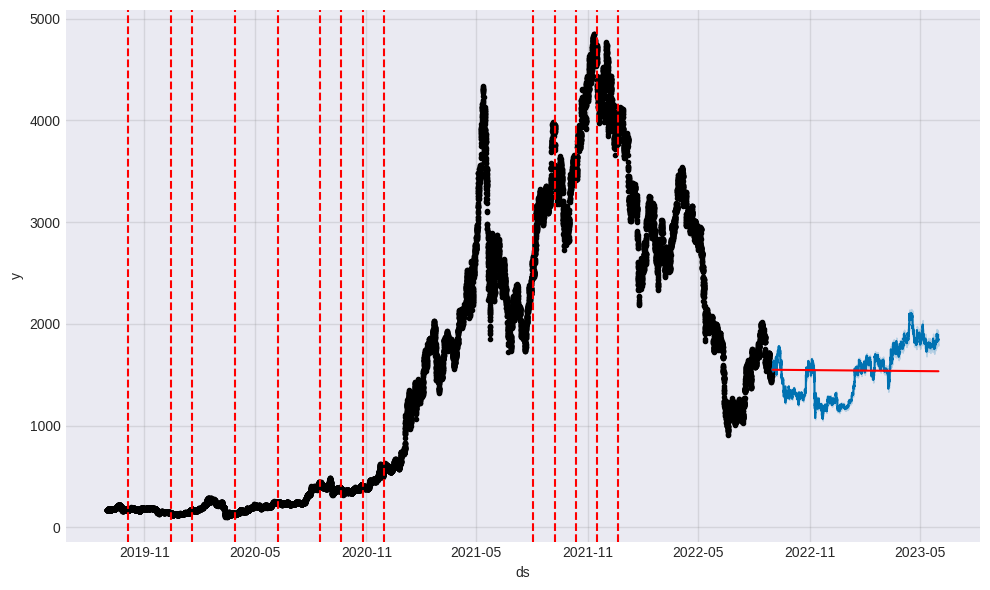

In [24]:
# Plotting changepoints

fig = model_fbprophet.plot(forecast_fb)

a = add_changepoints_to_plot(fig.gca(), model_fbprophet, forecast_fb)

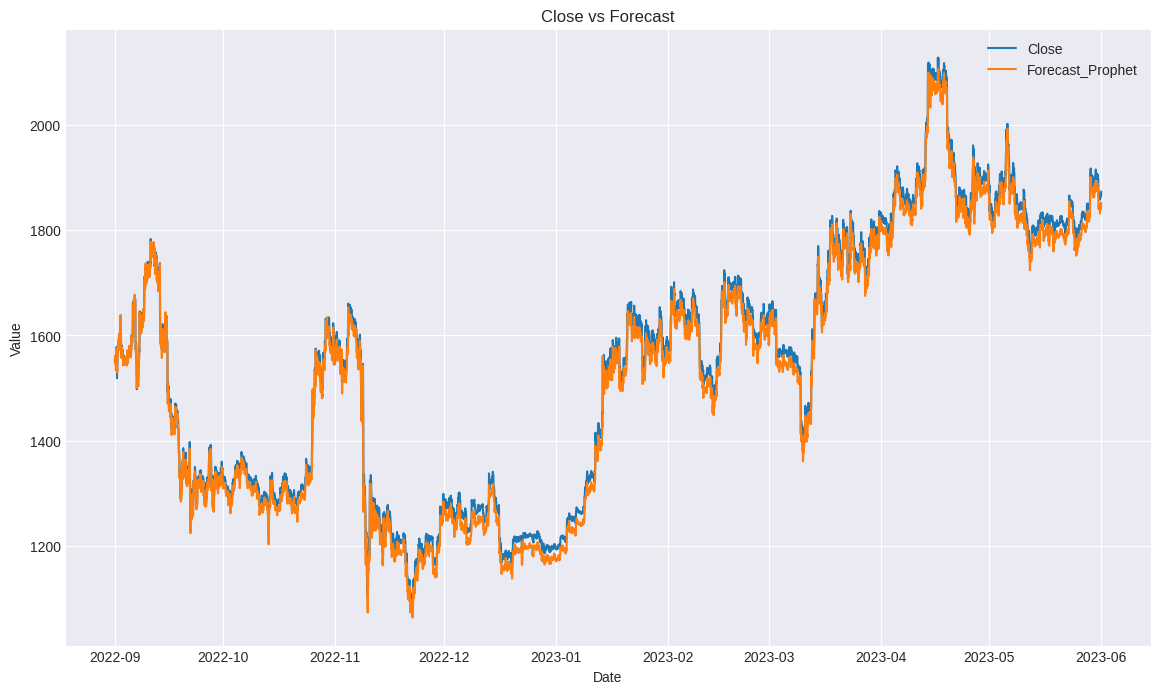

In [25]:
# plt.figure(figsize=(20, 7))

plt.plot(df_test["date"], df_test[["close", "Forecast_Prophet"]])

plt.legend(["Close", "Forecast_Prophet"])

plt.xlabel("Date")
plt.ylabel("Value")

plt.title("Close vs Forecast")

plt.show()


In [26]:
# Results Prophet Model

test_mae_prophet = round(mean_absolute_error(df_test['close'], df_test['Forecast_Prophet']), 2)
test_rmse_prophet = round(np.sqrt(mean_squared_error(df_test['close'], df_test['Forecast_Prophet'])), 2)
test_r2_prophet = round(r2_score(df_test['close'], df_test['Forecast_Prophet'])*100, 2)

print(f"Prophet's Test MAE : {test_mae_prophet}")
print(f"Prophet's Test RMSE : {test_rmse_prophet}")
print(f"Prophet's Test R2 : {test_r2_prophet}")

Prophet's Test MAE : 18.67
Prophet's Test RMSE : 19.65
Prophet's Test R2 : 99.38


In [ ]:
# save your model or results

joblib.dump(model_fbprophet, '/content/drive/MyDrive/Colab Notebooks/01 Omdena/Bahrain - Crypto/Saved Models/ETH/model_fbprophet_eth.pkl')

['/content/drive/MyDrive/Colab Notebooks/01 Omdena/Bahrain - Crypto/Saved Models/ETH/model_fbprophet_eth.pkl']

In [ ]:
# load_fb = joblib.load("/content/drive/MyDrive/Colab Notebooks/01 Omdena/Bahrain - Crypto/Saved Models/ETH/model_fbprophet_eth.pkl")

In [ ]:
# load_fb

## XGBoost

In [27]:
# Train/Test Split

split_date = "2022-09-01"

train_split = data_ETH['date'] <= split_date
test_split = data_ETH['date'] > split_date

train_xg = data_ETH[train_split]
test_xg = data_ETH[test_split]

In [28]:
columns = ['open', 'high', 'low', 'Volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume']

In [29]:
X_train, y_train = train_xg[columns], train_xg.close
X_test, y_test = test_xg[columns], test_xg.close

### RandomSearch

In [ ]:
reg = xgb.XGBRegressor()

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],

}


In [ ]:
model_xg  = RandomizedSearchCV(
                reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [ ]:
model_xg.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                                              0.8, 0.9, 1],
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [1, 3, 4, 5, 6, 7],
                                        'min_child_weight': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 11, 12, 13,
                                                             14],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000],
                                        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9, 1]},
                   verbose=3)

In [ ]:
print(f"Model Best Stimator : {model_xg.best_estimator_}")


Model Best Stimator : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9, colsample_bynode=None, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=11, missing=nan, monotone_constraints=None,
             n_estimators=944, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [ ]:
print(f"Model Best Score : {model_xg.best_score_}")
print(f"Model Best Stimator : {model_xg.best_estimator_}")
print(f"Model Best Parameters : {model_xg.best_estimator_.get_params()}")

In [ ]:
best_xg_model = model_xg.best_estimator_

In [32]:
best_xg_model = joblib.load("/content/drive/MyDrive/Colab Notebooks/01 Omdena/Bahrain - Crypto/Saved Models/ETH/xg_boost_ran_eth.pkl")

<ipython-input-33-4b43bae2ddf7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_xg['Predicted_close'] = best_xg_model.predict(X_train)


<Axes: >

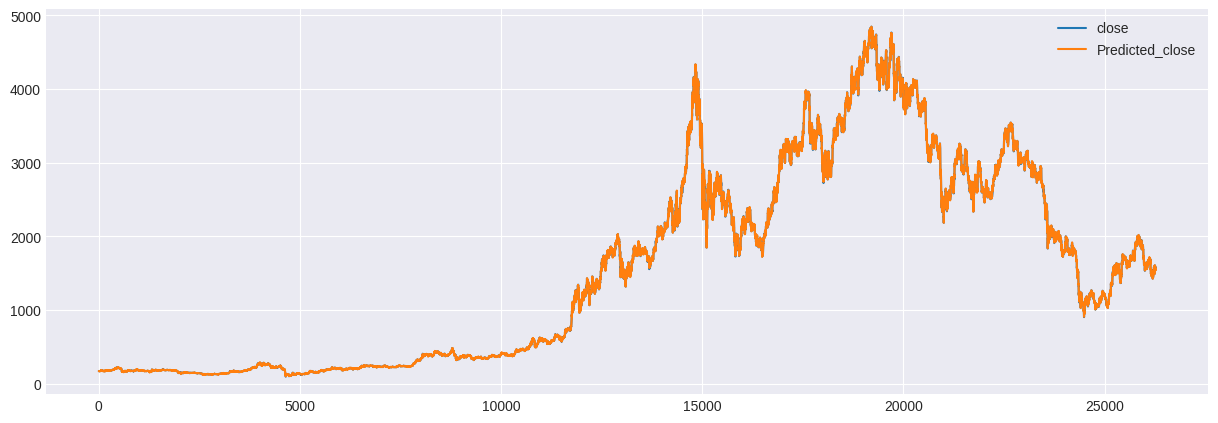

In [33]:
# Plot Actual vs Prediction

train_xg['Predicted_close'] = best_xg_model.predict(X_train)

train_xg[['close','Predicted_close']].plot(figsize=(15, 5))

In [34]:
test_xg['Forecast_XGBoost'] = best_xg_model.predict(X_test)

overall_data = pd.concat([train_xg, test_xg], sort=False)

<ipython-input-34-abf891e90dab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_xg['Forecast_XGBoost'] = best_xg_model.predict(X_test)


<Axes: >

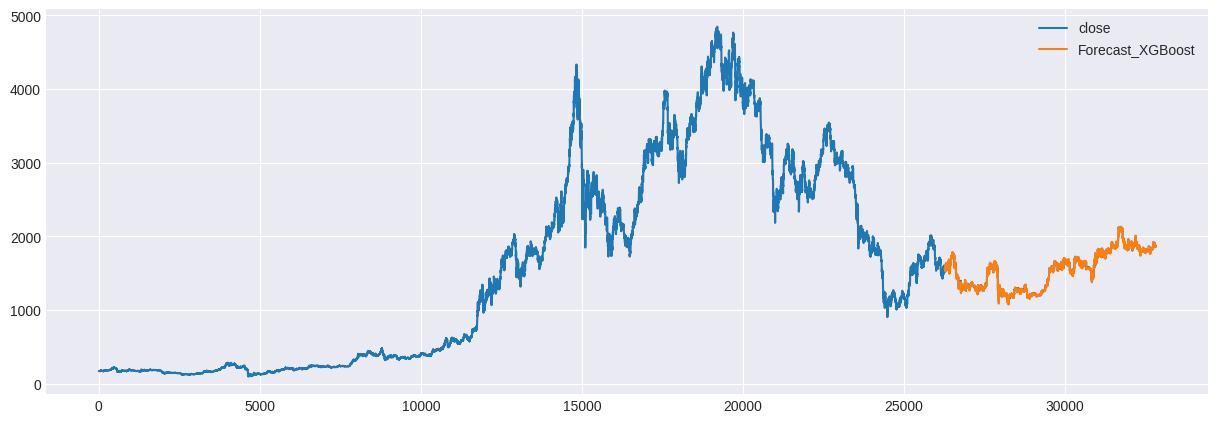

In [35]:
# Plot whole timeframe

overall_data[['close', 'Forecast_XGBoost']].plot(figsize=(15, 5))

In [37]:
# Results XGBoost Model

test_mae_xgboost = round(mean_absolute_error(test_xg['close'], test_xg['Forecast_XGBoost']))
test_rmse_xgboost = round(np.sqrt(mean_squared_error(test_xg['close'], test_xg['Forecast_XGBoost'])))
test_r2_xgboost = r2_score(test_xg['close'], test_xg['Forecast_XGBoost'])

print(f"test MAE XGBOOST : {test_mae_xgboost}")
print(f"test RMSE XGBOOST : {test_rmse_xgboost}")
print(f"test R2 XGBOOST : {test_r2_xgboost}")

test MAE XGBOOST : 5
test RMSE XGBOOST : 7
test R2 XGBOOST : 0.9991127420397194


In [ ]:
#save your model or results

# joblib.dump(best_xg_model, "/content/drive/MyDrive/Colab Notebooks/01 Omdena/Bahrain - Crypto/Saved Models/ETH/xg_boost_ran_eth.pkl")

['/content/drive/MyDrive/Colab Notebooks/01 Omdena/Bahrain - Crypto/Saved Models/ETH/xg_boost_ran_eth.pkl']

In [ ]:
#load your model for further usage

# load_xg = joblib.load("/content/drive/MyDrive/Colab Notebooks/01 Omdena/Bahrain - Crypto/Saved Models/ETH/xg_boost_ran_eth.pkl")

## LSTM

In [38]:
ETH_LSTM = data_ETH.copy()

In [40]:
ETH_LSTM = ETH_LSTM.drop(columns=[ "quote_volume", "count", "taker_buy_volume", "taker_buy_quote_volume"])


In [41]:
ETH_LSTM.shape

(32821, 6)

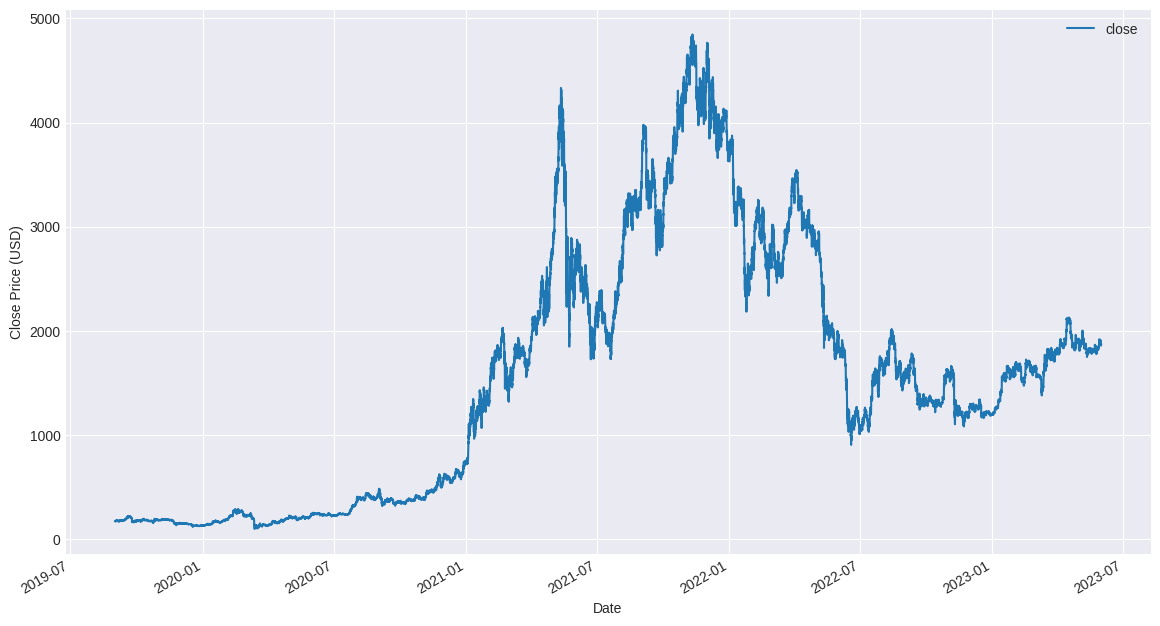

In [42]:
ax = ETH_LSTM.plot(x='date', y='close')

ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)");

### Normalization

In [48]:
scaler = MinMaxScaler()

close_price = ETH_LSTM.close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [49]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

### Preprocessing

In [50]:
# Creating Sequences and 3 Dim for LSTM

SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.8)

In [51]:
X_train.shape

(26176, 99, 1)

In [52]:
X_test.shape

(6545, 99, 1)

### Model Training

In [ ]:
WINDOW_SIZE = SEQ_LEN - 1

model=Sequential()

model.add(GRU(32,return_sequences=True,input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(0.20))

model.add(GRU(32,return_sequences=True))
model.add(Dropout(0.20))

model.add(GRU(32))
# model.add(Dropout(0.20))

model.add(Dense(1))


model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

checkpoint_path = 'bi_my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [checkpoint, earlystopping, lr_schedule]

BATCH_SIZE = 64

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    callbacks=callbacks
)

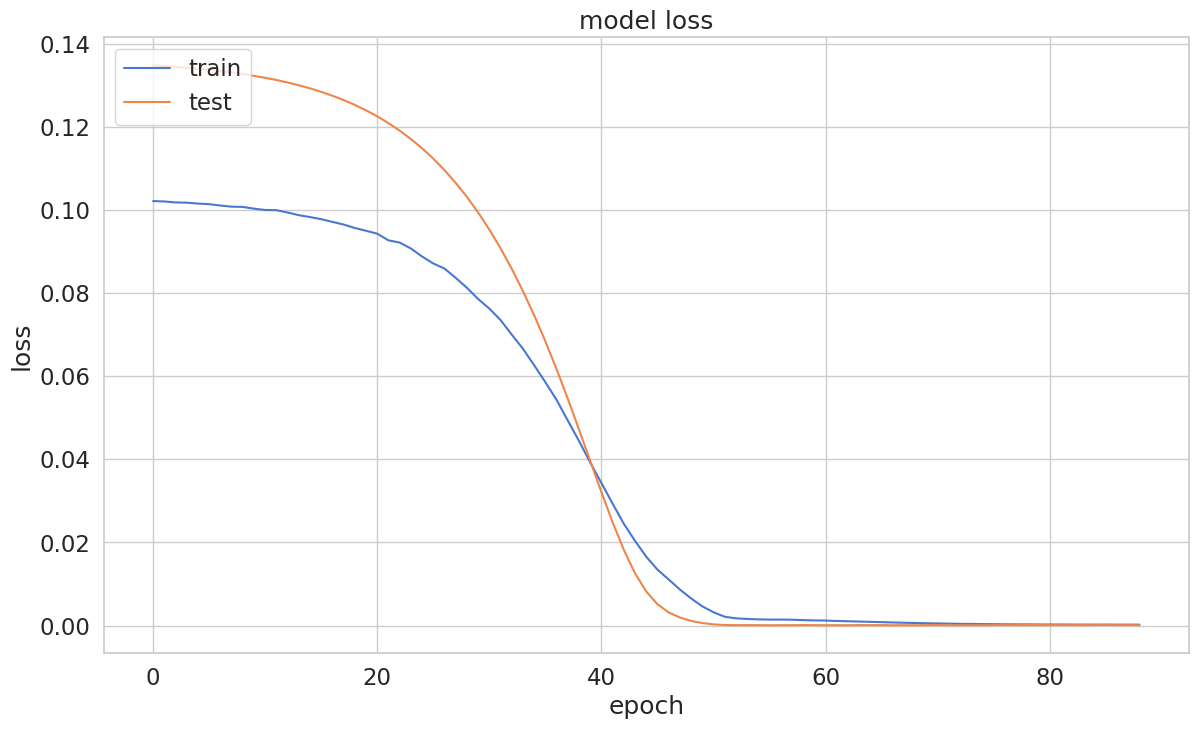

In [ ]:
# Plotting Train/Val Curve

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()

### Save Model

In [ ]:
model.save("model.keras")

In [53]:
model_load = load_model("/content/drive/MyDrive/Colab Notebooks/01 Omdena/Bahrain - Crypto/Saved Models/ETH/model-eth.keras")

In [54]:
model_load.evaluate(X_test, y_test)

205/205 [==============================] - 9s 35ms/step - loss: 1.8184e-05


1.8183647625846788e-05

### Prediction

In [56]:
# Prediction

y_hat = model_load.predict(X_test)

205/205 [==============================] - 7s 34ms/step


In [57]:
# Rescaling

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

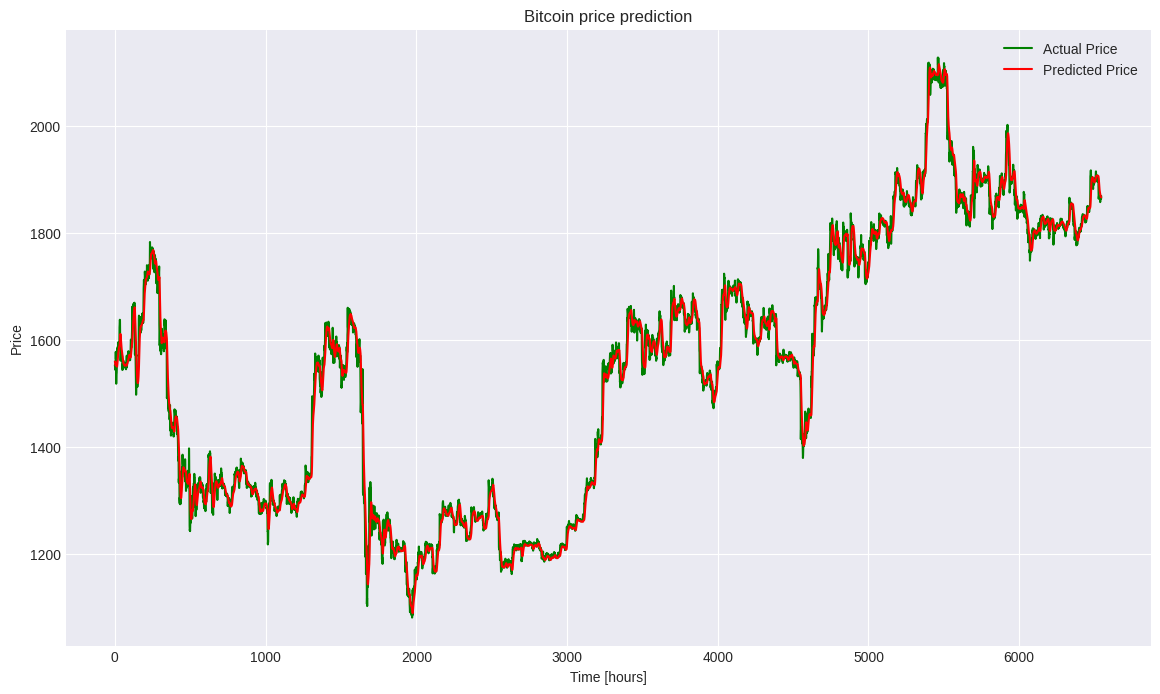

In [58]:
# Plotting Actual vs. Predicted

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [hours]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();

In [59]:
# Results LSTM

test_mae_LSTM= round(mean_absolute_error(y_test_inverse, y_hat_inverse), 2)
test_rmse_LSTM = round(np.sqrt(mean_squared_error(y_test_inverse, y_hat_inverse)), 2)
test_r2_LSTM = round(r2_score(y_test_inverse, y_hat_inverse)*100, 2)

print(f"test MAE LSTM : {test_mae_LSTM}")
print(f"test RMSE LSTM : {test_rmse_LSTM}")
print(f"test R2 LSTM : {test_r2_LSTM}")

test MAE LSTM : 13.04
test RMSE LSTM : 20.26
test R2 LSTM : 99.34


## Results Modeling

In [68]:
# Overall Results

results = {
    "METRIC": ["MAE", "RMSE", "R2"],
    "XGBoost": [test_mae_xgboost, test_rmse_xgboost, test_r2_xgboost],
    "FBProphet": [test_mae_prophet, test_rmse_prophet, test_r2_prophet],
    "LSTM": [test_mae_LSTM, test_rmse_LSTM, test_r2_LSTM]}

df_results = pd.DataFrame(results).round(1)
df_results

,METRIC,XGBoost,FBProphet,LSTM
0,MAE,5.0,18.7,13.0
1,RMSE,7.0,19.6,20.3
2,R2,1.0,99.4,99.3
